### Проект "Создание модели классификации для оценки потенциальных просрочек по платежам заемщиков"
#### Цель проекта - создать модель-классификатор. Классификатор должен оценивать потенциальных заемщиков и относить их к одному из двух классов: 1 - будет просрочка по кредиту, 0 - просрочки по кредиту не будет
1. Целевая переменная - Credit Default<br>
2. Метрика качества: f1-score (>0.75)<br>
3. Класс 1 - была просрочка по кредиту<br>
4. Класс 0 - просрочки по кредиту не было<br>

#### Для корректной работы скрипта необходимо в 4й по счету ячейке указать правильный путь к папке, в которой хранятся данные для тестовой и тренировочной выборок (переменная "path_to_folder"). В эту же папку будет произведен экспорт предсказанных классов в файл predicted.csv

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import seaborn as sns
import random

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
# Для корректной работы скрипта необходимо указать путь до папки, где храняться тренировочный датасет, и датасет из "продакшена"
path_to_folder = r'C:\Users\lazar\Downloads'


path_to_train = os.path.join(path_to_folder, 'project_train.csv')
path_to_data = os.path.join(path_to_folder, 'project_test.csv')
path_to_export = os.path.join(path_to_folder, 'predicted.csv')

In [4]:
df = pd.read_csv(path_to_train, encoding='utf-8')

### Название и физический смысл признаков:
Home Ownership	-	Домовладение<br>
Annual Income	-	Годовой доход<br>
Years in current job	-	Количество лет на текущем месте работе<br>
Tax Liens	-	Налоговые обременения<br>
Number of Open Accounts	-	Количество открытых счетов<br>
Years of Credit History	-	Количество лет кредитной истории<br>
Maximum Open Credit	-	Максимальный открытый кредит<br>
Number of Credit Problems	-	Количество проблем с кредитом<br>
Months since last delinquent	-	Количество месяцев с последней просрочки платежа<br>
Bankruptcies	-	Количество банкротств<br>
Purpose	-	Цель кредита<br>
Term	-	Срок кредита<br>
Current Loan Amount	-	Текущая сумма кредита<br>
Current Credit Balance	-	Текущий кредитный баланс<br>
Monthly Debt	-	Ежемесячный долг<br>
Credit Score	-	Кредитный рейтинг<br>

Credit Default	-	Факт невыполнения кредитных обязательств (целевая переменная)


In [5]:
df.head(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


### I. Знакомство с датасетом

In [6]:
print(f'Количество признаков: {df.shape[1] - 1}')
print(f'Количество наблюдений: {df.shape[0]}')

Количество признаков: 16
Количество наблюдений: 7500


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.0,1168386.0,1640137.00,1.014934e+07
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.0,0.0,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.0,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.5,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.5,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.0,0.0,0.00,7.000000e+00
Months since last delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.0,32.0,50.00,1.180000e+02
Bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.0,0.0,0.00,4.000000e+00
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.0,309573.0,519882.00,1.000000e+08
Current Credit Balance,7500.0,2.898332e+05,3.178714e+05,0.0,114256.5,209323.0,360406.25,6.506797e+06


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [9]:
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [10]:
duplicated = df[df.duplicated()]
duplicated
# Вывод: дублирующиеся строки не найдены

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default


#### Промежуточный вывод:
1. В целях оптимизации занимаемой памяти, необходимо вручную переопределить типы данных<br>
2. Обнаружены пропуски в признаках Annual Income, Years in current job, Months since last delinquent, Bankruptcies, Credit Score<br>
3. Обнаружен дисбаланс классов: 25 / 75

### II. Визуальное определение коррелирующих признаков:

Columns names in order:
Index(['Annual Income', 'Tax Liens', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 'Months since last delinquent',
       'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt', 'Credit Score', 'Credit Default'],
      dtype='object')


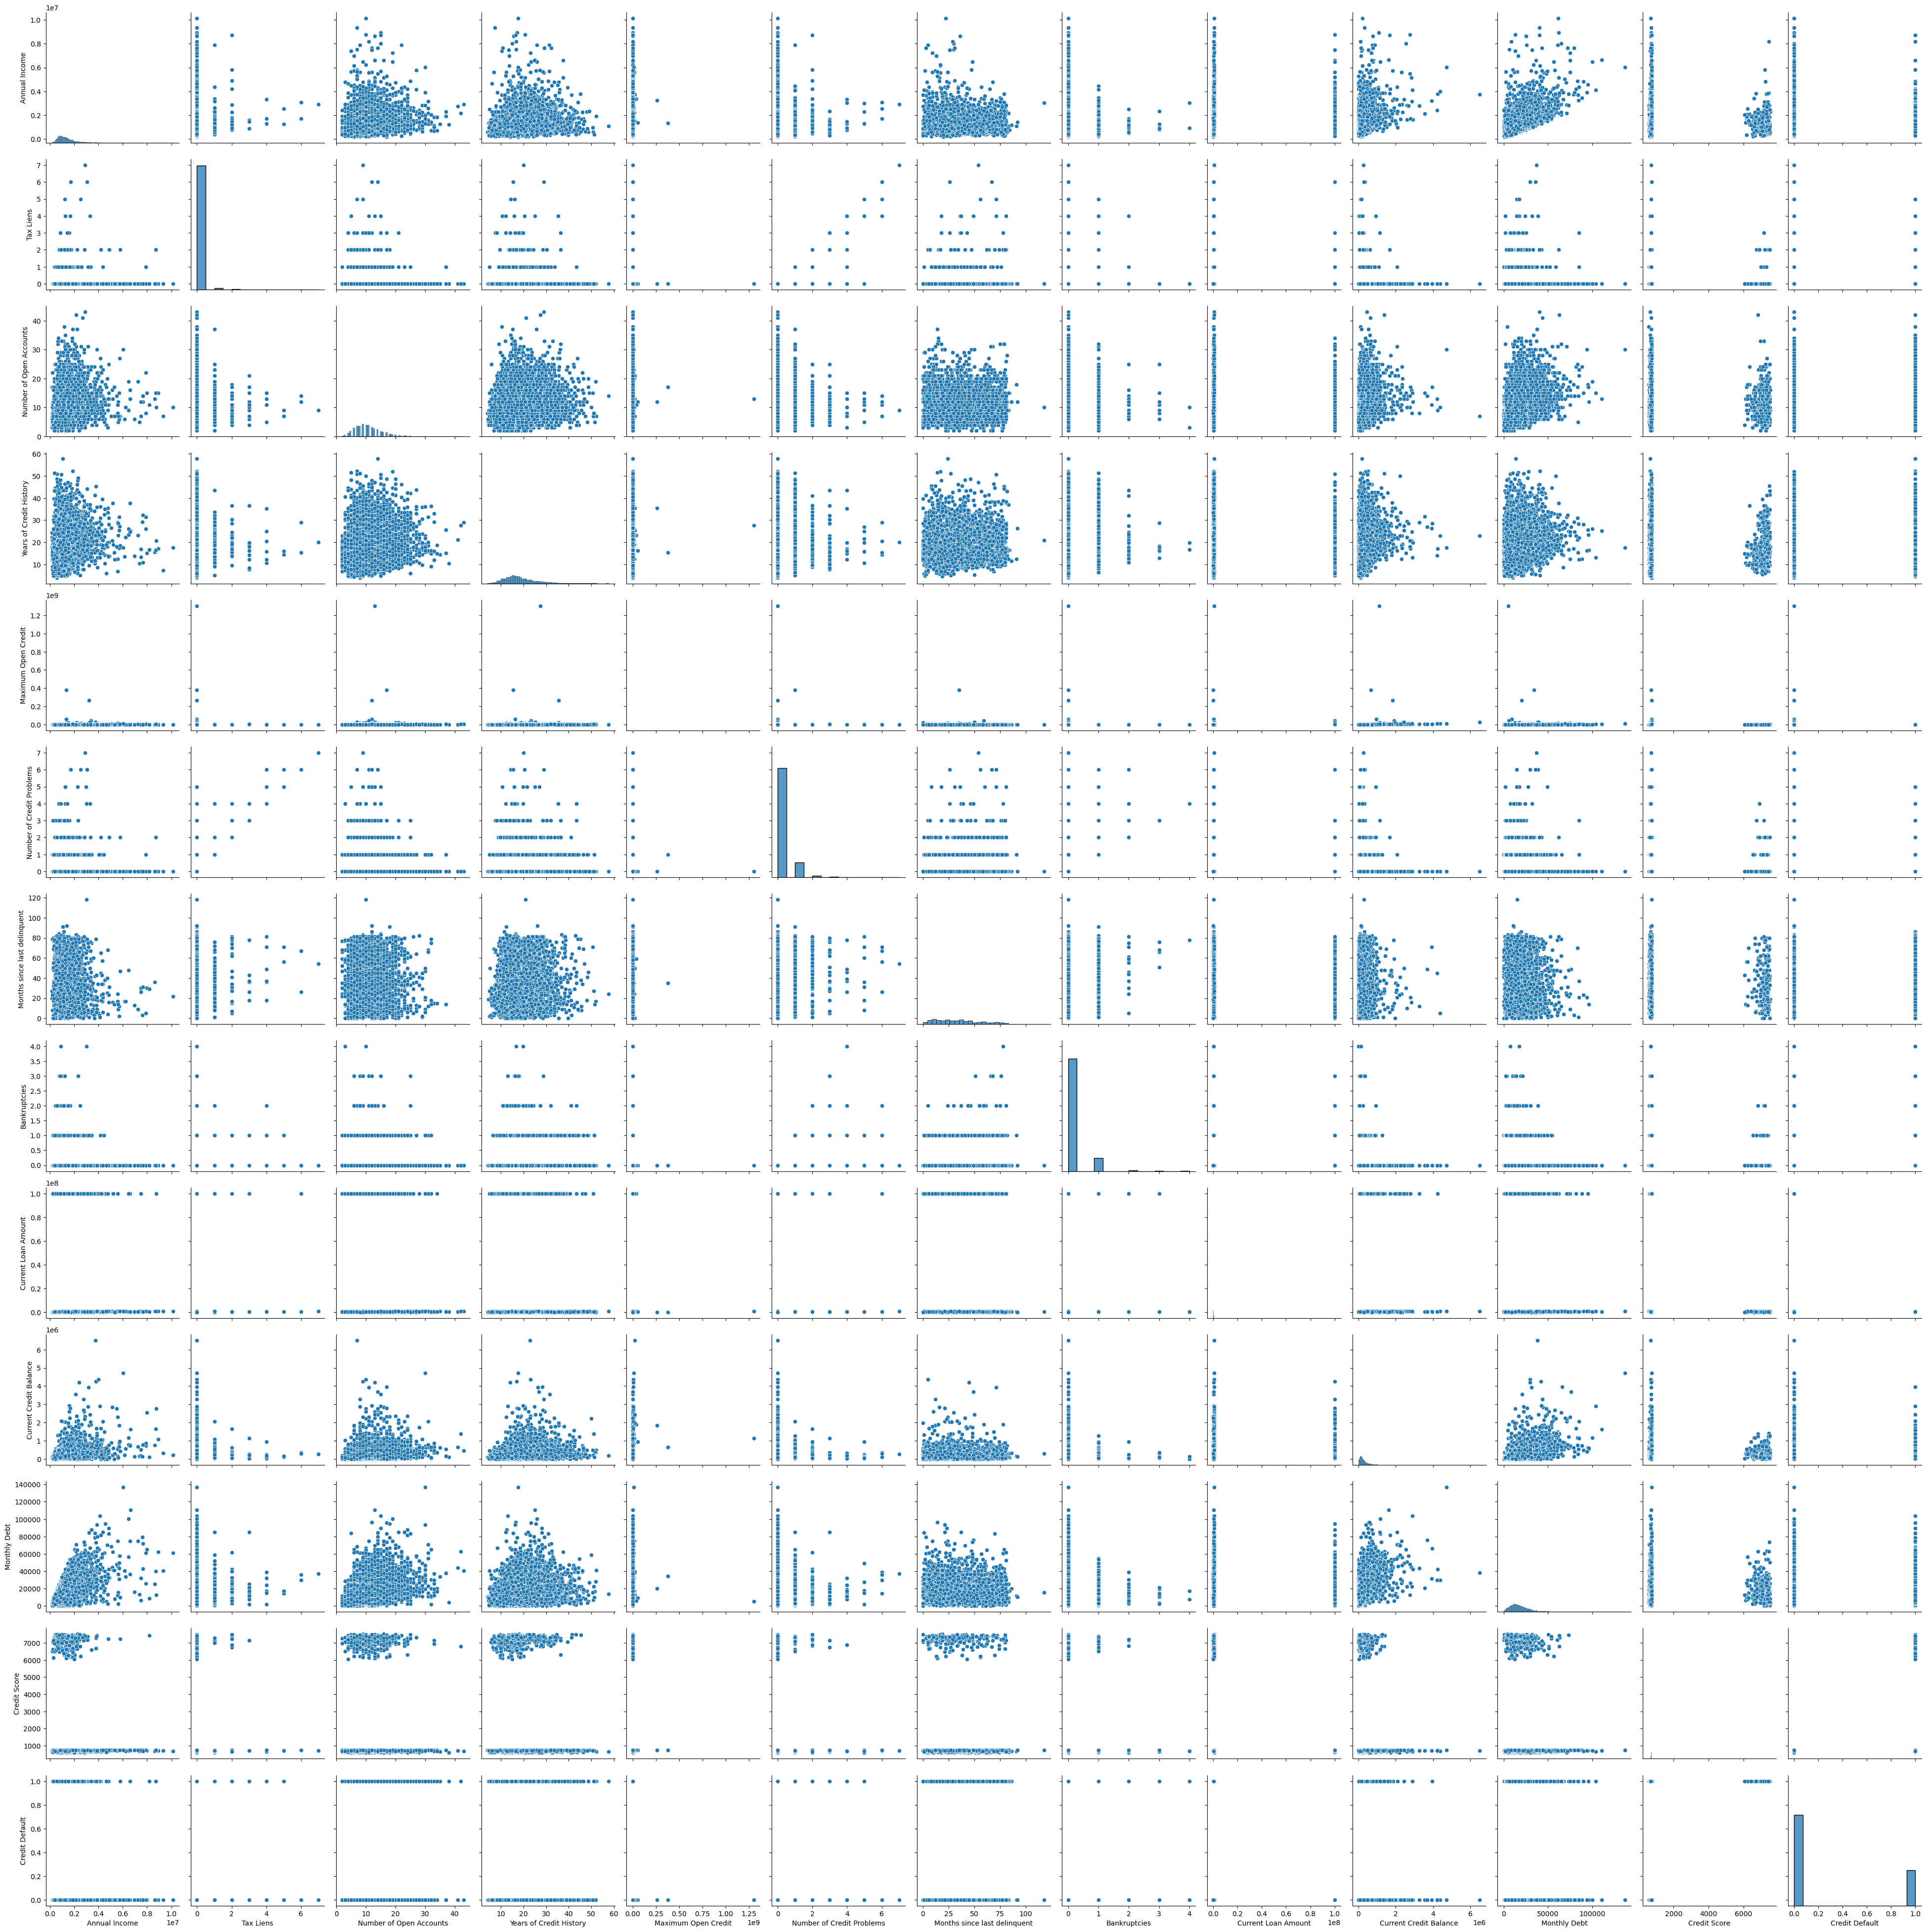

In [11]:
#sns.pairplot(df.loc[:, ['Home Ownership', 'Annual Income', 'Number of Open Accounts']])
print(f'Columns names in order:\n{df.select_dtypes(include=["int64", "float64"]).columns}')
sns.pairplot(df)
plt.gcf().set_size_inches(40, 40)
plt.show()

Вывод: необходимо проверить на наличие корреляций следующие признаки:<br>
a) Tax Liens и Number of Credit Problems

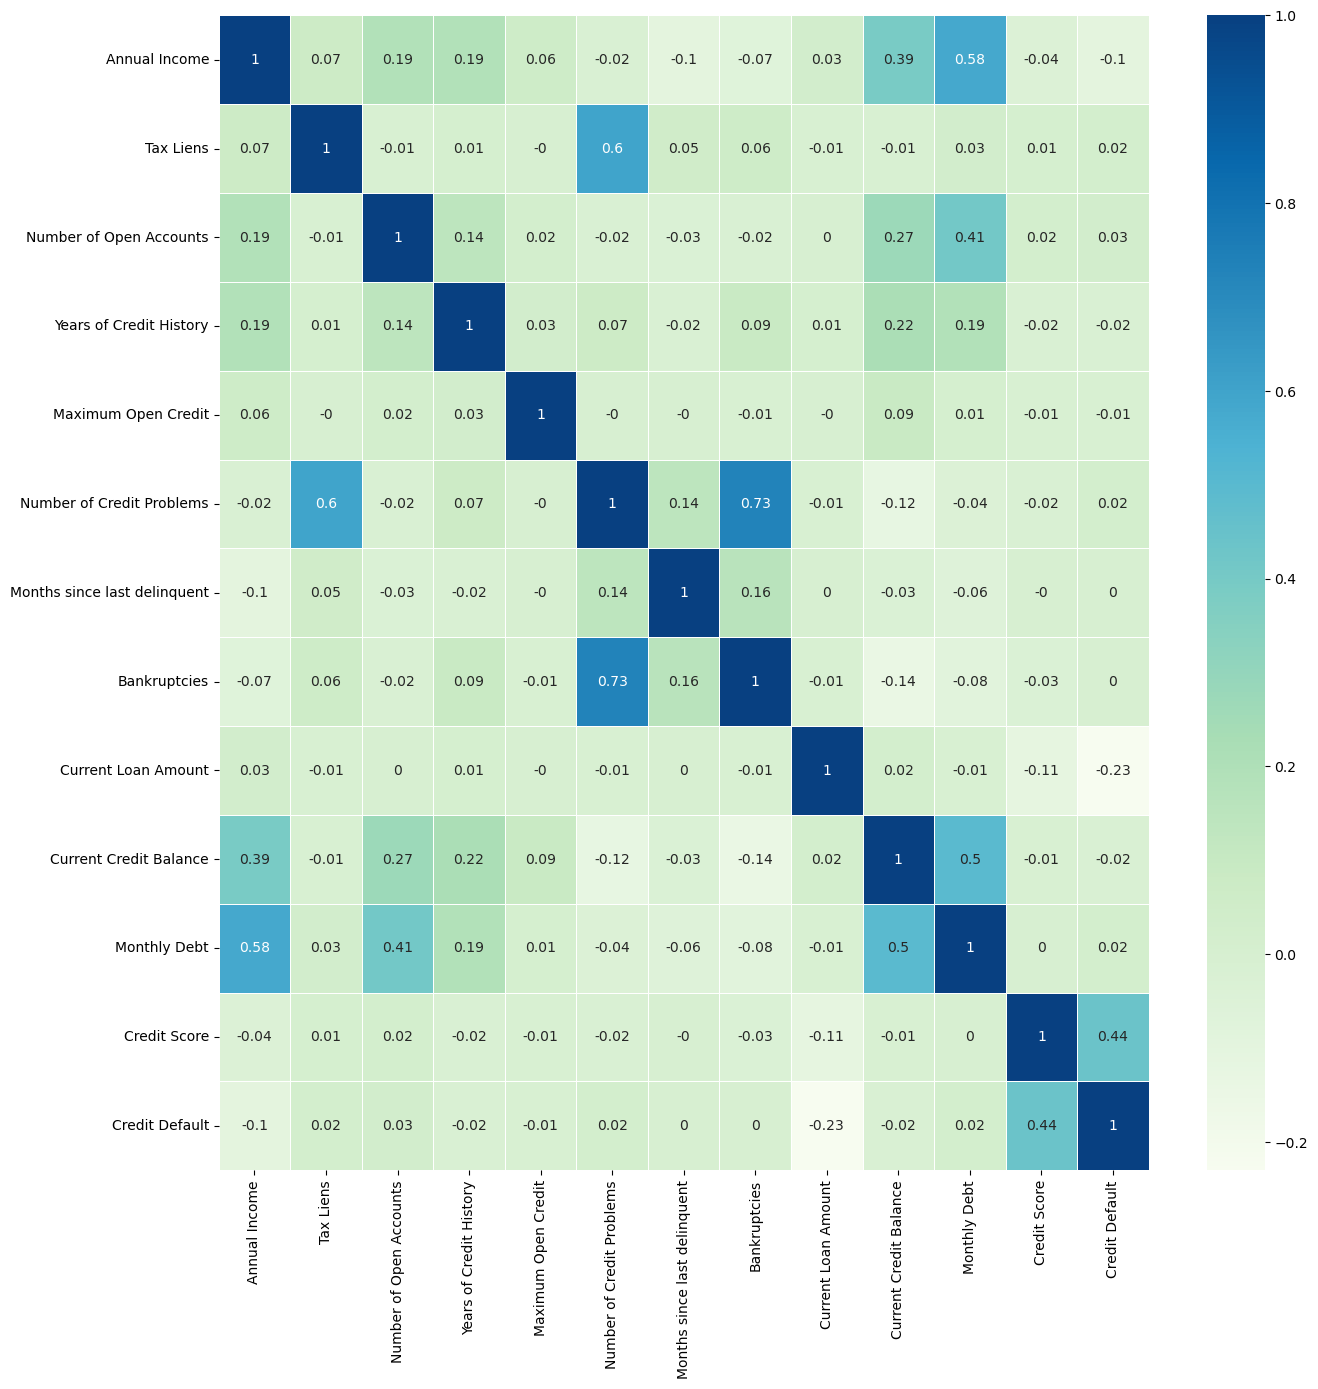

In [12]:
sns.heatmap(df.corr().round(2), annot=True, linewidths=.5, cmap='GnBu')
plt.gcf().set_size_inches(15,15)
plt.show()

#### Вывод:
Коэффициент корреляции меньше 0.7 - следовательно, корреляция между признаками не является слишком сильной. Было принято решение сохранить все признаки в датасете

### III. Подготовка датасета к работе - устранение недочетов, найденных в пунктах I и II

#### Переопределение типов данных:

In [13]:
# 1. Оптимизация занимаемой памяти - приведение к наиболее подходящему типу данных
df['Tax Liens'] = df['Tax Liens'].astype('Int64')
df['Number of Open Accounts'] = df['Number of Open Accounts'].astype('Int64')
df['Number of Credit Problems'] = df['Number of Credit Problems'].astype('Int64')
df['Months since last delinquent'] = df['Months since last delinquent'].astype('Int64')
df['Bankruptcies'] = df['Bankruptcies'].astype('Int64')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   Int64  
 4   Number of Open Accounts       7500 non-null   Int64  
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   Int64  
 8   Months since last delinquent  3419 non-null   Int64  
 9   Bankruptcies                  7486 non-null   Int64  
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

#### Заполнение пропусков:

Количество пропусков в столбце "Annual Income": 20.76%


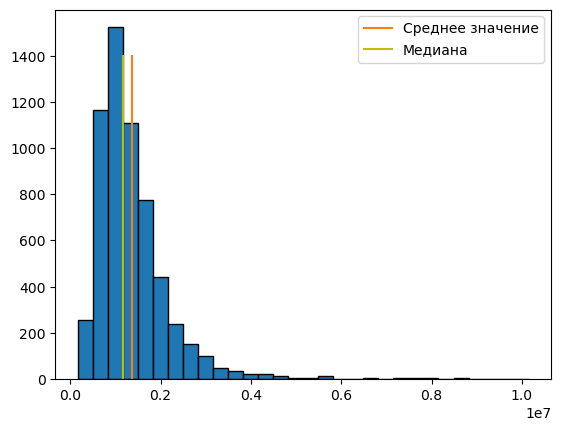

In [14]:
# Годовой доход:
print(f'Количество пропусков в столбце "Annual Income": {round(df[df["Annual Income"].isnull()].shape[0] / df.shape[0] * 100, 2)}%')
plt.hist(df['Annual Income'], ec='black', bins=30)
plt.plot([df['Annual Income'].mean(), df['Annual Income'].mean()], [0, 1400], label = 'Среднее значение')
plt.plot([df['Annual Income'].median(), df['Annual Income'].median()], [0, 1400], label = 'Медиана', color='y')
plt.legend()
plt.show()

In [15]:
# Медианное значение ближе подходит к центру распределения столбца Annual Income,
# поэтому пропуски в данном признаке заполним медианой
annual_income_none_filler = df['Annual Income'].median()
df.loc[df['Annual Income'].isnull(), 'Annual Income'] = df['Annual Income'].median()

Уникальные значения столбца:
 [nan '10+ years' '8 years' '6 years' '7 years' '5 years' '1 year'
 '< 1 year' '4 years' '3 years' '2 years' '9 years']

Количество пропусков: 4.95%


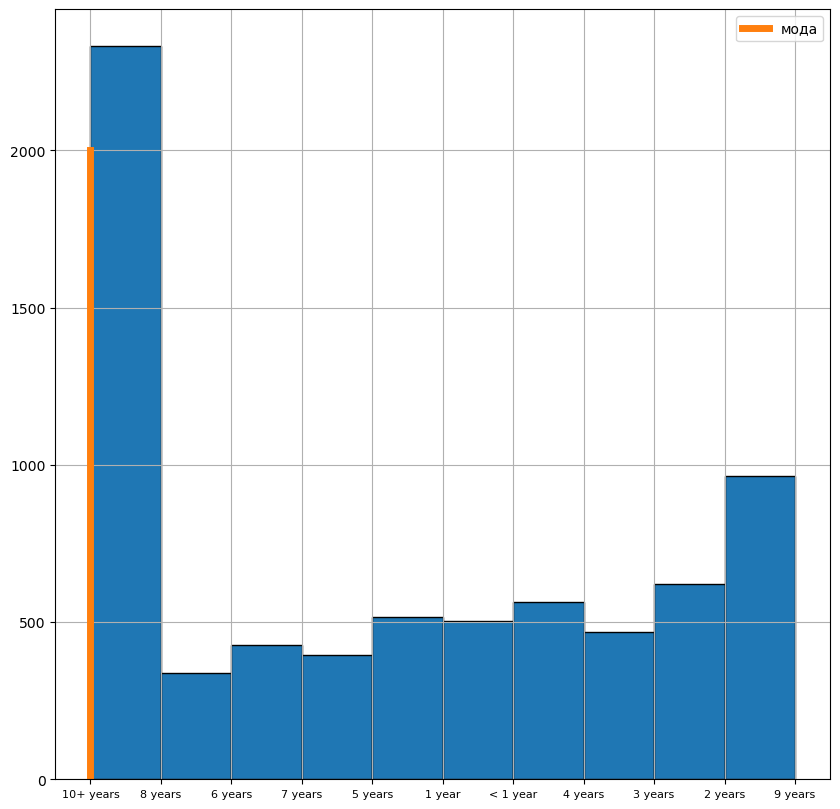

In [16]:
plt.gcf().set_size_inches(10, 10.)
print(f'Уникальные значения столбца:\n {df["Years in current job"].unique()}')
print()
print(f'Количество пропусков: {round(df[df["Years in current job"].isnull()].shape[0] / df.shape[0] * 100, 2)}%')
df['Years in current job'].hist(ec='black')
mode = df['Years in current job'].mode().tolist()[0]
plt.plot([mode, mode], [0, 2000], linewidth=5, label='мода')
plt.xticks(size=8)
plt.legend()
plt.show()

In [17]:
# Вывод: наиболее часто-встречающееся значение признака - 10+ years. Заполним этим значением пропуски в столбце:
years_in_current_job_filler = df['Years in current job'].mode().tolist()[0]
df.loc[df['Years in current job'].isnull(), 'Years in current job'] = df['Years in current job'].mode().tolist()[0]
df['Years in current job'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 7500 entries, 0 to 7499
Series name: Years in current job
Non-Null Count  Dtype 
--------------  ----- 
7500 non-null   object
dtypes: object(1)
memory usage: 58.7+ KB


In [18]:
if "Months since last delinquent" in df.columns:
    print(f'Количество пропусков в столбце "Months since last delinquent": {round(df[df["Months since last delinquent"].isnull()].shape[0] / df.shape[0] * 100, 2)}%')
# В данном столбце слишком много пропусков, поэтому его лучше выкинуть из обработки. При желании, в дальнейшем можно
# поэкспериментировать, и добавить его в итоговую модель
if "Months since last delinquent" in df.columns:
    df.drop("Months since last delinquent", inplace=True, axis=1)
print(f'Есть ли столбец "Months since last delinquent" в признаках? {"Months since last delinquent" in df.columns}')

Количество пропусков в столбце "Months since last delinquent": 54.41%
Есть ли столбец "Months since last delinquent" в признаках? False


Количество пропусков в столбце "Bankruptcies": 0.19%


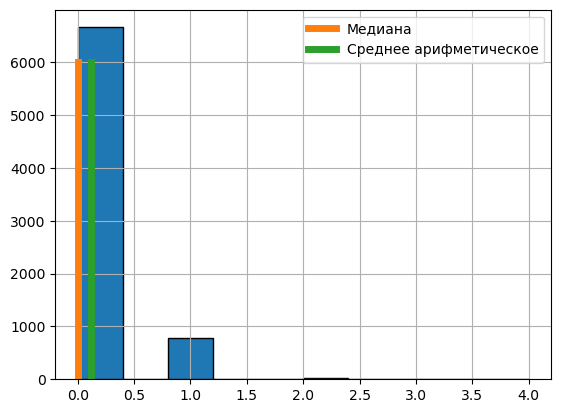

Вывод: анализируя возможные принимаемые значения, лучше данный столбец перевести в категориальный признак. Пропуски лучше заполнить модой


In [19]:
print(f'Количество пропусков в столбце "Bankruptcies": {round(df[df["Bankruptcies"].isnull()].shape[0] / df.shape[0] * 100, 2)}%')
df['Bankruptcies'].hist(ec='black')
plt.plot([df['Bankruptcies'].median(), df['Bankruptcies'].median()], [0, 6000], linewidth=5, label='Медиана')
plt.plot([df['Bankruptcies'].mean(), df['Bankruptcies'].mean()], [0, 6000], linewidth=5, label='Среднее арифметическое')
plt.legend()
plt.show()
print('Вывод: анализируя возможные принимаемые значения, лучше данный столбец перевести в категориальный признак. Пропуски лучше заполнить модой')

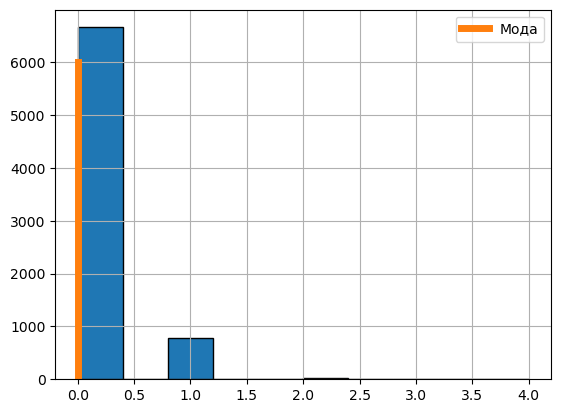

<class 'pandas.core.series.Series'>
RangeIndex: 7500 entries, 0 to 7499
Series name: Bankruptcies
Non-Null Count  Dtype 
--------------  ----- 
7500 non-null   object
dtypes: object(1)
memory usage: 58.7+ KB


In [20]:
df['Bankruptcies'] = df['Bankruptcies'].astype('object')
df['Bankruptcies'].hist(ec='black')
plt.plot([df['Bankruptcies'].mode(), df['Bankruptcies'].mode()], [0, 6000], linewidth=5, label='Мода')
plt.legend()
plt.show()
bankruptcies_filler = df['Bankruptcies'].mode().tolist()[0]
df.loc[df['Bankruptcies'].isnull(), 'Bankruptcies'] = df['Bankruptcies'].mode().tolist()[0]
df['Bankruptcies'].info()

Количество пропусков в столбце "Credit Score": 20.76%
На всей выборке признака Credit Score: медиана - 731.0, ар.среднее - 1151.1
На выборке признака Credit Score > 1000: медиана - 7190.0, ар.среднее - 7115.1
На выборке признака Credit Score <= 1000: медиана - 729.0, ар.среднее - 720.7
Процент Credit_Score > 1000 от всей выборки: 5.0%


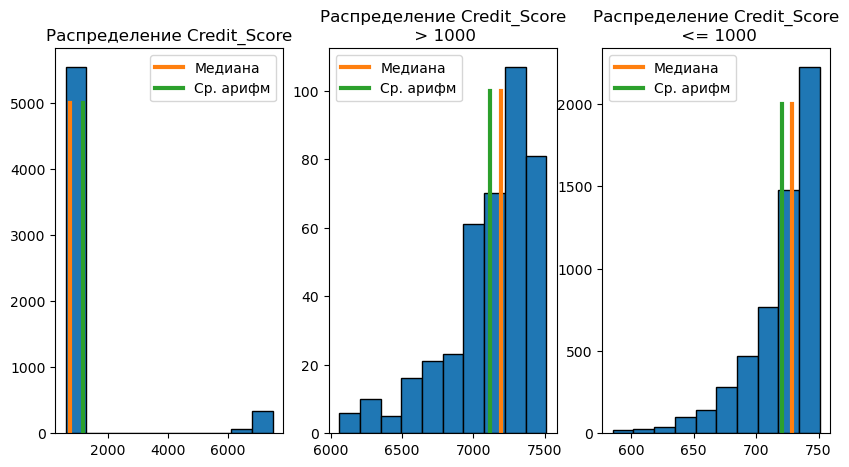

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
69,Home Mortgage,1408527.0,2 years,0,12,17.5,700062.0,0,0,other,Long Term,525998.0,174135.0,9320.0,6470.0,1
87,Home Mortgage,1533566.0,7 years,0,11,14.8,715462.0,0,0,debt consolidation,Short Term,210826.0,285475.0,18147.0,7440.0,1
94,Rent,1049294.0,3 years,0,5,6.1,249810.0,0,0,business loan,Short Term,337502.0,119529.0,15215.0,7010.0,1
96,Rent,757568.0,5 years,0,13,11.4,383548.0,0,0,debt consolidation,Short Term,210518.0,276583.0,11553.0,7320.0,1
116,Home Mortgage,1039984.0,10+ years,0,10,23.8,147950.0,0,0,debt consolidation,Short Term,224246.0,95456.0,13780.0,7390.0,1


In [21]:
print(f'Количество пропусков в столбце "Credit Score": {round(df[df["Credit Score"].isnull()].shape[0] / df.shape[0] * 100, 2)}%')
fig, axes = plt.subplots(nrows=1, ncols=3)
plt.gcf().set_size_inches(10, 5)
ax1, ax2, ax3 = axes.flatten()
ax1.hist(df['Credit Score'], ec='black')
median = df['Credit Score'].median()
mean = df['Credit Score'].mean()
print(f'На всей выборке признака Credit Score: медиана - {round(median, 1)}, ар.среднее - {round(mean, 1)}')
ax1.plot([median,median], [0, 5000], linewidth=3, label='Медиана')
ax1.plot([mean,mean], [0, 5000], linewidth=3, label='Ср. арифм')
ax1.legend()
ax1.set_title('Распределение Credit_Score')

ax2.hist(df[df['Credit Score'] > 1000]['Credit Score'], ec='black')
median = df[df['Credit Score'] > 1000]['Credit Score'].median()
mean = df[df['Credit Score'] > 1000]['Credit Score'].mean()
print(f'На выборке признака Credit Score > 1000: медиана - {round(median, 1)}, ар.среднее - {round(mean, 1)}')
ax2.plot([median,median], [0, 100], linewidth=3, label='Медиана')
ax2.plot([mean,mean], [0, 100], linewidth=3, label='Ср. арифм')
ax2.legend()
ax2.set_title('Распределение Credit_Score\n > 1000')

ax3.hist(df[df['Credit Score'] <= 1000]['Credit Score'], ec='black')
median = df[df['Credit Score'] <= 1000]['Credit Score'].median()
mean = df[df['Credit Score'] <= 1000]['Credit Score'].mean()
print(f'На выборке признака Credit Score <= 1000: медиана - {round(median,1)}, ар.среднее - {round(mean,1)}')
ax3.plot([median,median], [0, 2000], linewidth=3, label='Медиана')
ax3.plot([mean,mean], [0, 2000], linewidth=3, label='Ср. арифм')
ax3.legend()
ax3.set_title('Распределение Credit_Score\n <= 1000')

print(f'Процент Credit_Score > 1000 от всей выборки: {round(df[df["Credit Score"] > 1000].shape[0] / df.shape[0],2) * 100}%')
plt.show()
df[df['Credit Score'] > 1000].head(5)

#### Комментарий:
Credit_Score - интересный признак. Возможно, значения от 6000 до 7500 - выбросы, однако я так не считаю. 
На производстве данный момент определенно стоит уточнить у поставщика датасета. Учитывая, что процент 
наблюдений со значениями > 1000 равен 5%, было принято решение заполнить Null - значения медианой 
наблюдений признака Credit_Score со значениями <= 1000

In [22]:
credit_score_filler = df[df['Credit Score'] <= 1000]['Credit Score'].median()
df.loc[df['Credit Score'].isnull(), 'Credit Score'] = df[df['Credit Score'] <= 1000]['Credit Score'].median()
df['Credit Score'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 7500 entries, 0 to 7499
Series name: Credit Score
Non-Null Count  Dtype  
--------------  -----  
7500 non-null   float64
dtypes: float64(1)
memory usage: 58.7 KB


In [23]:
# Проверка, что все Null - значения заполнены:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Home Ownership             7500 non-null   object 
 1   Annual Income              7500 non-null   float64
 2   Years in current job       7500 non-null   object 
 3   Tax Liens                  7500 non-null   Int64  
 4   Number of Open Accounts    7500 non-null   Int64  
 5   Years of Credit History    7500 non-null   float64
 6   Maximum Open Credit        7500 non-null   float64
 7   Number of Credit Problems  7500 non-null   Int64  
 8   Bankruptcies               7500 non-null   object 
 9   Purpose                    7500 non-null   object 
 10  Term                       7500 non-null   object 
 11  Current Loan Amount        7500 non-null   float64
 12  Current Credit Balance     7500 non-null   float64
 13  Monthly Debt               7500 non-null   float

#### Балансировка классов:

In [24]:
'''
Т.к. наблюдений сравнительно немного, было принято выполнить балансировку классов методом дублирования наблюдений
для класса, который встречается реже
'''
while df[df['Credit Default'] == 1].shape[0] < df[df['Credit Default'] == 0].shape[0]:
    idx = random.choice(df.index[df['Credit Default'] == 1])
    df = pd.concat([df, df[df.index==idx]], ignore_index=True)

In [25]:
df[df.duplicated()].head(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
7500,Home Mortgage,1152996.0,8 years,0,10,12.9,271480.0,0,0,debt consolidation,Long Term,467258.0,138567.0,27095.0,7170.0,1
7501,Rent,571140.0,10+ years,0,8,15.6,271128.0,0,0,debt consolidation,Long Term,220440.0,137674.0,11004.0,722.0,1
7502,Rent,1168386.0,< 1 year,0,9,10.7,642092.0,0,0,debt consolidation,Short Term,312026.0,296685.0,13006.0,729.0,1
7503,Home Mortgage,1311114.0,7 years,0,22,13.6,409420.0,0,0,debt consolidation,Long Term,390368.0,191995.0,33761.0,738.0,1
7504,Rent,1168386.0,6 years,0,6,9.2,265738.0,0,0,debt consolidation,Long Term,223278.0,205865.0,6122.0,729.0,1


In [26]:
# Проверка, что балансировка классов выполнена успешно:
df['Credit Default'].value_counts()

0    5387
1    5387
Name: Credit Default, dtype: int64

### IV. Оценка корреляции признаков с целевой переменной

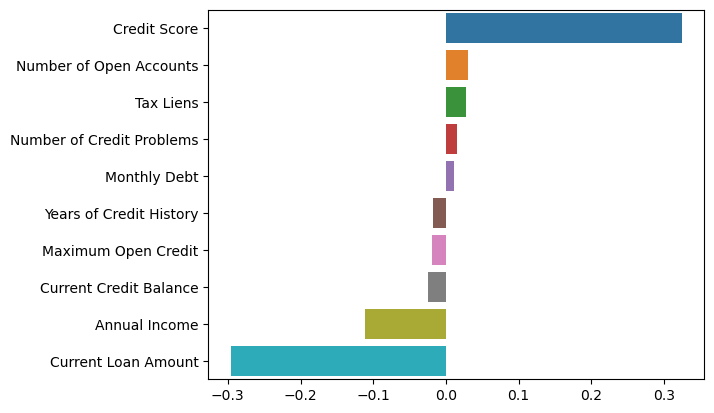

In [27]:
correlations = df.corr().iloc[:-1, -1].sort_values(ascending=False)
sns.barplot(x=correlations.values, y=correlations.index)
plt.show()

Вывод: все величины слабо коррелируют с целевой величиной.

### V. Анализ выбросов

In [28]:
# Поиск выбросов в категориальных признаках
string_columns = df.select_dtypes('object').columns.tolist()
for column in string_columns:
    print(f'current column: {column}')
    print(df[column].value_counts())
    print()

current column: Home Ownership
Home Mortgage    5060
Rent             4753
Own Home          939
Have Mortgage      22
Name: Home Ownership, dtype: int64

current column: Years in current job
10+ years    3925
2 years      1015
3 years       864
< 1 year      812
1 year        739
5 years       716
4 years       682
6 years       625
7 years       574
8 years       479
9 years       343
Name: Years in current job, dtype: int64

current column: Bankruptcies
0    9622
1    1084
2      54
3      10
4       4
Name: Bankruptcies, dtype: int64

current column: Purpose
debt consolidation      8485
other                    977
home improvements        556
business loan            230
buy a car                123
medical bills            112
take a trip               65
small business            65
buy house                 52
major purchase            52
wedding                   19
moving                    15
educational expenses      10
vacation                  10
renewable energy         

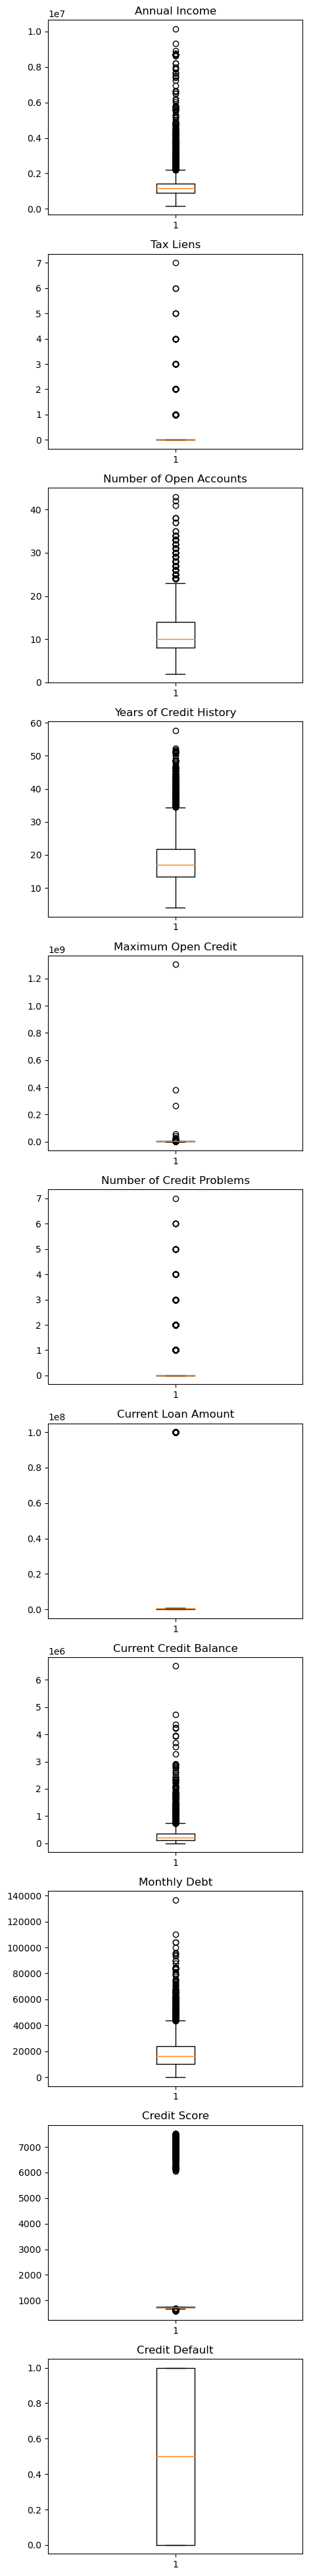

In [29]:
# Поиск выбросов в числовых признаках
numeric_columns = df.select_dtypes(include = ['Int64', 'float64', 'int64']).columns.tolist()
fig, axes = plt.subplots(nrows = len(numeric_columns))
plt.gcf().set_size_inches(5,50)
for i, column in enumerate(numeric_columns):
    axes[i].boxplot(df[column])
    axes[i].set_title(column)

plt.show()

Вывод: есть подозрения на выбросы в следующих признаках: Maximum Open Credit, Current Loan Amount, Current Credit Balance

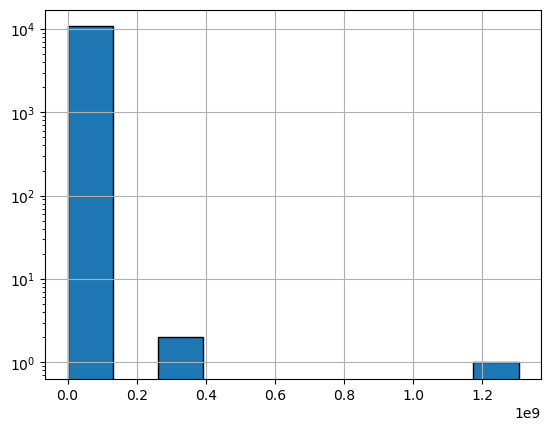

Количество наблюдений со значениями признака "Maximum Open Credit", превышающими 1e7: 19


In [30]:
df['Maximum Open Credit'].hist(ec='black')
plt.yscale('log')
plt.show()
print(f'Количество наблюдений со значениями признака "Maximum Open Credit", превышающими 1e7: {df[df["Maximum Open Credit"] > 1e7].shape[0]}')

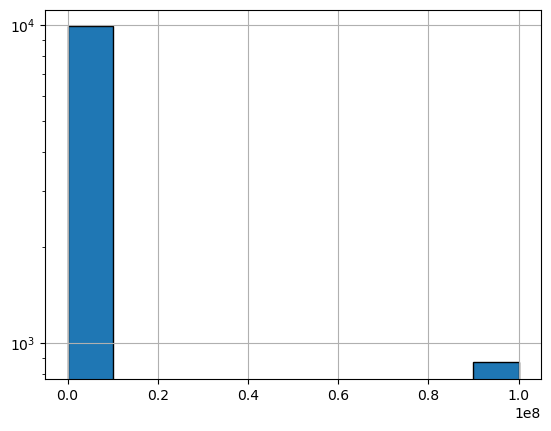

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,10+ years,0,11,26.3,685960.0,1,1,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
2,Home Mortgage,751412.0,8 years,0,11,35.0,1182434.0,0,0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
6,Home Mortgage,1511108.0,10+ years,0,9,20.3,388124.0,0,0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
22,Rent,463790.0,10+ years,0,6,28.3,288442.0,0,0,debt consolidation,Short Term,99999999.0,157700.0,5063.0,738.0,0
27,Rent,1004055.0,8 years,0,7,14.5,328394.0,0,0,debt consolidation,Short Term,99999999.0,195966.0,6041.0,734.0,0


In [31]:
df['Current Loan Amount'].hist(ec='black')
plt.yscale('log')
plt.show()
df[df['Current Loan Amount'] > 0.1e7].head(5)

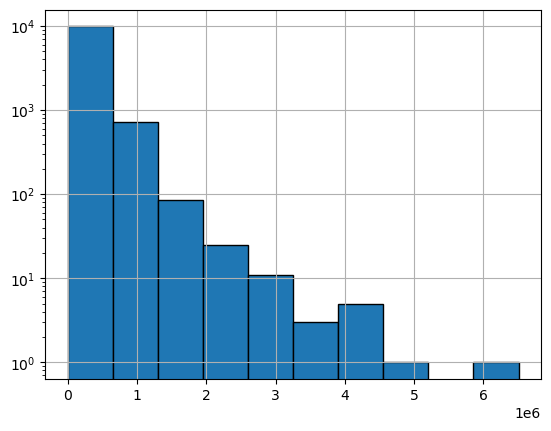

In [32]:
df['Current Credit Balance'].hist(ec='black')
plt.yscale('log')
plt.show()

### Выводы:
1) Признак Maximum Open Credit имеет выбросы (значения, превышающие 1e7) в количестве 16 штук. Заменим эти значения на медианные<br>
2) Признак Current Loan Amoun имеет выбросы (значения, превышающие 1e7) в количестве 890 штук. Заменим эти значения на медианные

In [33]:
df.loc[df['Current Loan Amount'] > 0.1e7, 'Current Loan Amount'] = df['Current Loan Amount'].median()
(df['Current Loan Amount'] > 0.1e7).unique()

array([False])

In [34]:
df.loc[df['Maximum Open Credit'] > 0.1e7, 'Maximum Open Credit'] = df['Maximum Open Credit'].median()
(df['Maximum Open Credit'] > 0.1e7).unique()

array([False])

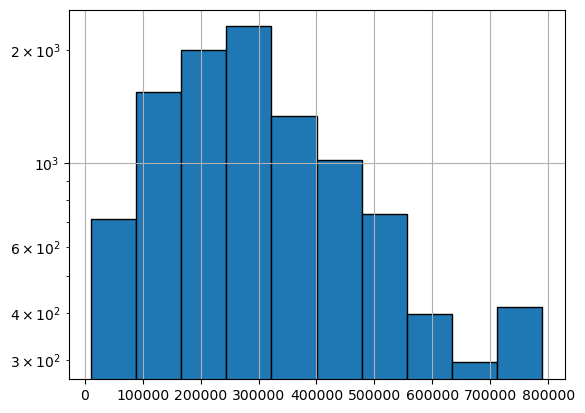

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default


In [35]:
# Проверка:
df['Current Loan Amount'].hist(ec='black')
plt.yscale('log')
plt.show()
df[df['Current Loan Amount'] > 0.1e7].head(5)

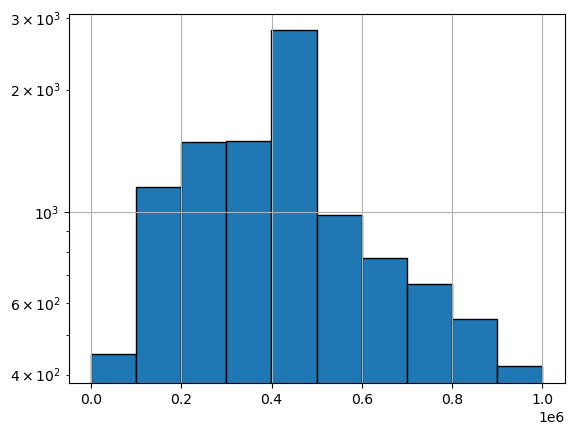

0

In [36]:
# Проверка:
df['Maximum Open Credit'].hist(ec='black')
plt.yscale('log')
plt.show()
df[df['Maximum Open Credit'] > 1e7].shape[0]

### VI. Выбор наилучшей модели для дальнейшей классификации
Анализируемые модели:<br>
1. Логистическая регрессия<br>
2. K ближайших соседей<br>
3. XGBoost<br>
4. CatBoost<br>
5. LightGBM

In [37]:
X = pd.get_dummies(df, columns = df.select_dtypes('object').columns.tolist())
X.drop('Credit Default', axis=1, inplace=True)
Y = df.loc[:, 'Credit Default']

X = X.to_numpy()
Y = Y.to_numpy()

C:\Users\lazar\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [38]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=13)

#### Логистическая регрессия:

In [39]:
standart_scaler = StandardScaler()
standart_scaler.fit(x_train)
x_train_logistic = standart_scaler.transform(x_train)

lr = LogisticRegression()
lr.fit(x_train_logistic, y_train)
y_pred_logistic = lr.predict(x_train_logistic)

print('Оценка метрик на обучающих данных:')
print(classification_report(y_train, y_pred_logistic))

Оценка метрик на обучающих данных:
              precision    recall  f1-score   support

           0       0.64      0.77      0.70      3740
           1       0.71      0.57      0.63      3801

    accuracy                           0.67      7541
   macro avg       0.68      0.67      0.67      7541
weighted avg       0.68      0.67      0.67      7541



In [40]:
x_test_logistic = standart_scaler.transform(x_test)
y_pred_logistic_test = lr.predict(x_test_logistic)

print('Оценка метрик на тестовых данных:')
print(classification_report(y_pred_logistic_test, y_test))

Оценка метрик на тестовых данных:
              precision    recall  f1-score   support

           0       0.77      0.64      0.70      1979
           1       0.55      0.69      0.61      1254

    accuracy                           0.66      3233
   macro avg       0.66      0.67      0.66      3233
weighted avg       0.68      0.66      0.66      3233



#### K ближайших соседей (KNN):

In [41]:
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(x_train)
x_train_knn = min_max_scaler.transform(x_train)

knn = KNeighborsClassifier()
knn.fit(x_train_knn, y_train)
y_pred_knn = knn.predict(x_train_knn)

print('Оценка метрик на обучающих данных:')
print(classification_report(y_train, y_pred_knn))

Оценка метрик на обучающих данных:
              precision    recall  f1-score   support

           0       0.83      0.77      0.80      3740
           1       0.79      0.84      0.82      3801

    accuracy                           0.81      7541
   macro avg       0.81      0.81      0.81      7541
weighted avg       0.81      0.81      0.81      7541



In [42]:
x_test_knn = min_max_scaler.transform(x_test)
y_pred_knn_test = knn.predict(x_test_knn)

print('Оценка метрик на тестовых данных:')
print(classification_report(y_pred_knn_test, y_test))

Оценка метрик на тестовых данных:
              precision    recall  f1-score   support

           0       0.68      0.72      0.70      1543
           1       0.73      0.69      0.71      1690

    accuracy                           0.70      3233
   macro avg       0.71      0.71      0.70      3233
weighted avg       0.71      0.70      0.71      3233



#### XGBoost:

In [43]:
xgb_classifier = xgb.XGBClassifier(random_state=13)
xgb_classifier.fit(x_train, y_train)
y_pred_xgb = xgb_classifier.predict(x_train)

print('Оценка метрик на обучающих данных:')
print(classification_report(y_pred_xgb, y_train))

Оценка метрик на обучающих данных:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      3774
           1       0.97      0.98      0.97      3767

    accuracy                           0.97      7541
   macro avg       0.97      0.97      0.97      7541
weighted avg       0.97      0.97      0.97      7541



In [44]:
y_pred_xgb_test = xgb_classifier.predict(x_test)

print('Оценка метрик на тестовых данных:')
print(classification_report(y_pred_xgb_test, y_test))

Оценка метрик на тестовых данных:
              precision    recall  f1-score   support

           0       0.80      0.85      0.83      1555
           1       0.85      0.81      0.83      1678

    accuracy                           0.83      3233
   macro avg       0.83      0.83      0.83      3233
weighted avg       0.83      0.83      0.83      3233



#### CatBoost:

In [45]:
cat = catb.CatBoostClassifier(silent = True, random_state=13)
cat.fit(x_train, y_train)
y_pred_cat = cat.predict(x_train)

print('Оценка метрик на обучающих данных:')
print(classification_report(y_pred_cat, y_train))

Оценка метрик на обучающих данных:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      3828
           1       0.90      0.92      0.91      3713

    accuracy                           0.91      7541
   macro avg       0.91      0.91      0.91      7541
weighted avg       0.91      0.91      0.91      7541



In [46]:
y_pred_cat_test = cat.predict(x_test)

print('Оценка метрик на тестовых данных:')
print(classification_report(y_pred_xgb_test, y_test))

Оценка метрик на тестовых данных:
              precision    recall  f1-score   support

           0       0.80      0.85      0.83      1555
           1       0.85      0.81      0.83      1678

    accuracy                           0.83      3233
   macro avg       0.83      0.83      0.83      3233
weighted avg       0.83      0.83      0.83      3233



#### LightGBM:

In [47]:
lgb = lgbm.LGBMClassifier(random_state=13)
lgb.fit(x_train, y_train)
y_pred_lgb = lgb.predict(x_train)

print('Оценка метрик на обучающих данных:')
print(classification_report(y_pred_lgb, y_train))

Оценка метрик на обучающих данных:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      3843
           1       0.91      0.93      0.92      3698

    accuracy                           0.92      7541
   macro avg       0.92      0.92      0.92      7541
weighted avg       0.92      0.92      0.92      7541



In [48]:
y_pred_lgb_test = lgb.predict(x_test)

print('Оценка метрик на тестовых данных:')
print(classification_report(y_pred_lgb_test, y_test))

Оценка метрик на тестовых данных:
              precision    recall  f1-score   support

           0       0.80      0.81      0.81      1634
           1       0.80      0.80      0.80      1599

    accuracy                           0.80      3233
   macro avg       0.80      0.80      0.80      3233
weighted avg       0.80      0.80      0.80      3233



### Вывод:
Наилучшую целеувую метрику (f1-score для класса 1) показали модели XGBoost и CatBoost.<br>
Окончательное предсказание будет выполнять, используя отечественную разработку - CatBoost

### VII. Создание финальной модели:

In [49]:
X = df.loc[:, df.columns.tolist()[:-1]]
Y = df.loc[:, df.columns.tolist()[-1]]

In [50]:
dummy_columns = X.select_dtypes('object').columns.tolist()
dummy_columns

['Home Ownership', 'Years in current job', 'Bankruptcies', 'Purpose', 'Term']

In [51]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, shuffle=True, random_state=13, test_size=0.3)

#### Параметры CatBoost:
1. n_estimators - количество деревьев в ансамбле (бустинге)
2. max_depth - максимальное количество веток (этажей) в дереве
3. cat_features - название всех колонок, которые должны быть закодированы one-hot
4. task_type - возможность запуска обучения на CPU / GPU

In [52]:
cat_params = {
        'n_estimators': [5,20,50,100,200,300,400,500],
        'max_depth': [3,5,7,10],
}

In [53]:
cat = catb.CatBoostClassifier(silent=False, cat_features=dummy_columns, random_state=13, task_type = 'CPU')

#### Параметры GridSearchCV:
1. scoring - анализируемая метрика
2. cv - количество бинов при кросс-валидации (None = 5 бинов)
3. n_jobs - количество параллельно - обучающихся моделей на разных процессорах. -1 = использовать максимум процессоров

In [54]:
%%time
gscv = GridSearchCV(cat, param_grid=cat_params, scoring='f1', cv=None, n_jobs=-1)
gscv.fit(x_train, y_train)

Learning rate set to 0.05656
0:	learn: 0.6708258	total: 61.7ms	remaining: 24.6s
1:	learn: 0.6554694	total: 119ms	remaining: 23.7s
2:	learn: 0.6390769	total: 176ms	remaining: 23.3s
3:	learn: 0.6270988	total: 236ms	remaining: 23.4s
4:	learn: 0.6146644	total: 299ms	remaining: 23.6s
5:	learn: 0.6053652	total: 361ms	remaining: 23.7s
6:	learn: 0.5915441	total: 424ms	remaining: 23.8s
7:	learn: 0.5837258	total: 486ms	remaining: 23.8s
8:	learn: 0.5770176	total: 553ms	remaining: 24s
9:	learn: 0.5697512	total: 617ms	remaining: 24.1s
10:	learn: 0.5643354	total: 682ms	remaining: 24.1s
11:	learn: 0.5589011	total: 746ms	remaining: 24.1s
12:	learn: 0.5561054	total: 766ms	remaining: 22.8s
13:	learn: 0.5521429	total: 835ms	remaining: 23s
14:	learn: 0.5483868	total: 902ms	remaining: 23.2s
15:	learn: 0.5425296	total: 969ms	remaining: 23.3s
16:	learn: 0.5381555	total: 1.03s	remaining: 23.3s
17:	learn: 0.5311276	total: 1.09s	remaining: 23.1s
18:	learn: 0.5261826	total: 1.15s	remaining: 23.1s
19:	learn: 0.52

GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x000001C4F0E025B0>,
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'n_estimators': [5, 20, 50, 100, 200, 300, 400, 500]},
             scoring='f1')

In [55]:
gscv.best_score_

0.8391152033301961

In [56]:
gscv.best_params_

{'max_depth': 10, 'n_estimators': 400}

In [57]:
# Создание модели с наилучшими подобранными параметарами:
final_cat = catb.CatBoostClassifier(silent=True, random_state=13, n_estimators=gscv.best_params_['n_estimators'], max_depth = gscv.best_params_['max_depth'], cat_features=dummy_columns, )
final_cat.fit(x_train, y_train)

In [58]:
final_y_pred = final_cat.predict(x_train)
print(classification_report(y_train, final_y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3740
           1       0.99      0.98      0.99      3801

    accuracy                           0.99      7541
   macro avg       0.99      0.99      0.99      7541
weighted avg       0.99      0.99      0.99      7541



In [59]:
final_y_pred_test = final_cat.predict(x_test)
print(classification_report(y_test, final_y_pred_test))

              precision    recall  f1-score   support

           0       0.86      0.85      0.85      1647
           1       0.84      0.86      0.85      1586

    accuracy                           0.85      3233
   macro avg       0.85      0.85      0.85      3233
weighted avg       0.85      0.85      0.85      3233



### VIII. Выполнение финального предсказания "в продакшене":

In [60]:
# Словарь с типами данных
d_type_dict = {
    'Annual Income': 'float64',
    'Years in current job': 'object',
    'Tax Liens': 'Int64',
    'Number of Open Accounts': 'Int64',
    'Years of Credit History': 'float64',
    'Maximum Open Credit': 'float64',
    'Number of Credit Problems': 'Int64',
    'Bankruptcies': 'object',
    'Purpose': 'object',
    'Term': 'object',
    'Current Loan Amount': 'float64',
    'Current Credit Balance': 'float64',
    'Monthly Debt': 'float64',
    'Credit Score': 'float64',
    'Credit Default': 'int64'
}

In [61]:
# Чтение данных:
data = pd.read_csv(path_to_data, encoding='utf-8', dtype = d_type_dict)

In [62]:
# Отброс признаков, по которым было принято решение не использовать в модели
data.drop('Months since last delinquent', axis=1, inplace=True)

In [63]:
# Заполнение Null - значений
data.loc[data['Annual Income'].isnull(), 'Annual Income'] = annual_income_none_filler
data.loc[data['Years in current job'].isnull(), 'Years in current job'] = years_in_current_job_filler
data.loc[data['Bankruptcies'].isnull(), 'Bankruptcies'] = bankruptcies_filler
data.loc[data['Credit Score'].isnull(), 'Credit Score'] = credit_score_filler

In [64]:
# Предсказание:
data_pred = final_cat.predict(data)
temp = pd.DataFrame({'predicted':data_pred})
temp

,predicted
0,0
1,0
2,1
3,0
4,0
...,...
2495,1
2496,1
2497,1
2498,0


In [65]:
# Экспорт предсказанных классов на диск:
temp.to_csv(path_to_export, encoding='utf-8', header=False, index=False)